<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/review-of-microbiological-quality-article?scriptVersionId=183417449" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center><i>Revisando articulo</i></center>
---

y pensando en cosas...

[link](https://www.sciencedirect.com/science/article/pii/S2352801X23001340)

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2352801X23001340-ga1_lrg.jpg" width="1500">

In [1]:
!pip install -q geemap
!pip install -q geedim
!pip install -q leafmap
# !pip install -q openpyxl

Cargando las librerìas a utilizar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geemap.foliumap as geemap
import seaborn as sns
import geemap.colormaps as cmap
import leafmap.foliumap as leafmap
import shapely 
import geopandas as gpd
import rasterio 
import rasterio.plot
import ee

Realizando la autentificaciòn de la api de Google Earth Engine

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1ATx3LY7wd6ujUJeQ688qIP5YM6Ab1f-nIjYjEa1GNh6eUmfml0HWnZPcJNA



Successfully saved authorization token.


# _Condiciones ambientales de la zona de estudio_

In [4]:
shp_area = shapely.geometry.Polygon([[-79.970979,-1.762202],[-79.970813,-1.762009],[-79.970775,-1.7618],
                                     [-79.970767,-1.76172],[-79.970491,-1.761403],[-79.970271,-1.761258],
                                     [-79.970164,-1.761092],[-79.969708,-1.760727],[-79.969767,-1.760062],
                                     [-79.968608,-1.758582],[-79.96849,-1.75855],[-79.968404,-1.758539],
                                     [-79.968222,-1.758035],[-79.967975,-1.757628],[-79.967589,-1.757649],
                                     [-79.96694,-1.757826],[-79.966875,-1.757735],[-79.967358,-1.757001],
                                     [-79.967723,-1.756153],[-79.967841,-1.755864],[-79.967862,-1.755537],
                                     [-79.967621,-1.755338],[-79.967186,-1.755472],[-79.966848,-1.755639],
                                     [-79.966189,-1.756271],[-79.965202,-1.756475],[-79.96474,-1.756518],
                                     [-79.963056,-1.757086],[-79.962857,-1.756668],[-79.963195,-1.756218],
                                     [-79.965234,-1.753816],[-79.960202,-1.750556],[-79.958078,-1.750684],
                                     [-79.956973,-1.750212],[-79.956264,-1.749762],[-79.957563,-1.7487],
                                     [-79.957724,-1.748314],[-79.958196,-1.748003],[-79.960427,-1.746931],
                                     [-79.960942,-1.746625],[-79.961404,-1.746164],[-79.961919,-1.74551],
                                     [-79.962605,-1.744094],[-79.964247,-1.744706],[-79.964456,-1.744395],
                                     [-79.965287,-1.742223],[-79.966934,-1.742572],[-79.966822,-1.743172],
                                     [-79.969214,-1.743682],[-79.971156,-1.744153],[-79.972368,-1.744615],
                                     [-79.974434,-1.744497],[-79.974992,-1.745596],[-79.975995,-1.747237],
                                     [-79.975973,-1.747462],[-79.975694,-1.747971],[-79.973366,-1.750432],
                                     [-79.97246,-1.752599],[-79.972256,-1.753076],[-79.972701,-1.75314],
                                     [-79.972529,-1.754824],[-79.972186,-1.758523],[-79.972186,-1.759328],
                                     [-79.971569,-1.760802],[-79.971317,-1.761478],[-79.970979,-1.762202]])

area_gdf = gpd.GeoDataFrame(geometry = [shp_area], crs = "EPSG:4326")

area_gdf.to_crs(32717, inplace = True)

area_gdf["Area (hec)"] = round(area_gdf.area[0]/10000, 3)

area_gdf["Perimetro (Km)"] = round(area_gdf.length[0]/1000, 3)

area_ee = geemap.gdf_to_ee(area_gdf)

centroide_ee = area_ee.geometry().centroid()

In [5]:
Map = leafmap.Map()

Map.add_basemap("HYBRID")

Map.add_gdf(area_gdf, style = {"color": "red", "fillOpacity": 0}, layer_name = "area")

Map

In [6]:
def create_reduce_region_function(geometry,reducer = ee.Reducer.mean(),scale = 1000,
                                  crs = 'EPSG:4326',bestEffort = True,
                                  maxPixels = 1e13,tileScale = 4):
    def reduce_region_function(img):
        stat = img.reduceRegion(
            reducer = reducer,
            geometry = geometry,
            scale = scale,
            crs = crs,
            bestEffort = bestEffort,
            maxPixels = maxPixels,
            tileScale = tileScale)
        return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
    return reduce_region_function

def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
        reducer = ee.Reducer.toList().repeat(prop_names.size()),
        selectors = prop_names).get('list')
    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [7]:
fecha_inicial = '2018-01-01'; fecha_final = '2020-12-31'

chirps =  ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                             .select(['precipitation'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = centroide_ee, 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

chirps_red = (ee.FeatureCollection(chirps.map(puntos_red)).filter(ee.Filter.notNull(chirps.first().bandNames())))

puntos_chirps = fc_to_dict(chirps_red).getInfo()

puntos_chirps = pd.DataFrame(puntos_chirps)

puntos_chirps['Fecha'] = pd.to_datetime(puntos_chirps["system:index"], format='%Y%m%d')

puntos_chirps.set_index('Fecha', inplace=True)

puntos_chirps = puntos_chirps.resample("ME").sum()

puntos_chirps = puntos_chirps.drop(columns = ["millis", "system:index"])
    
puntos_chirps.T

Fecha,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
precipitation,60.906219,162.684616,168.223579,58.132294,64.438945,7.989744,0.0,2.165908,7.168681,6.51331,...,177.874062,223.129251,39.354856,12.085018,0.224544,4.285586,8.198333,4.294172,0.0,59.366716


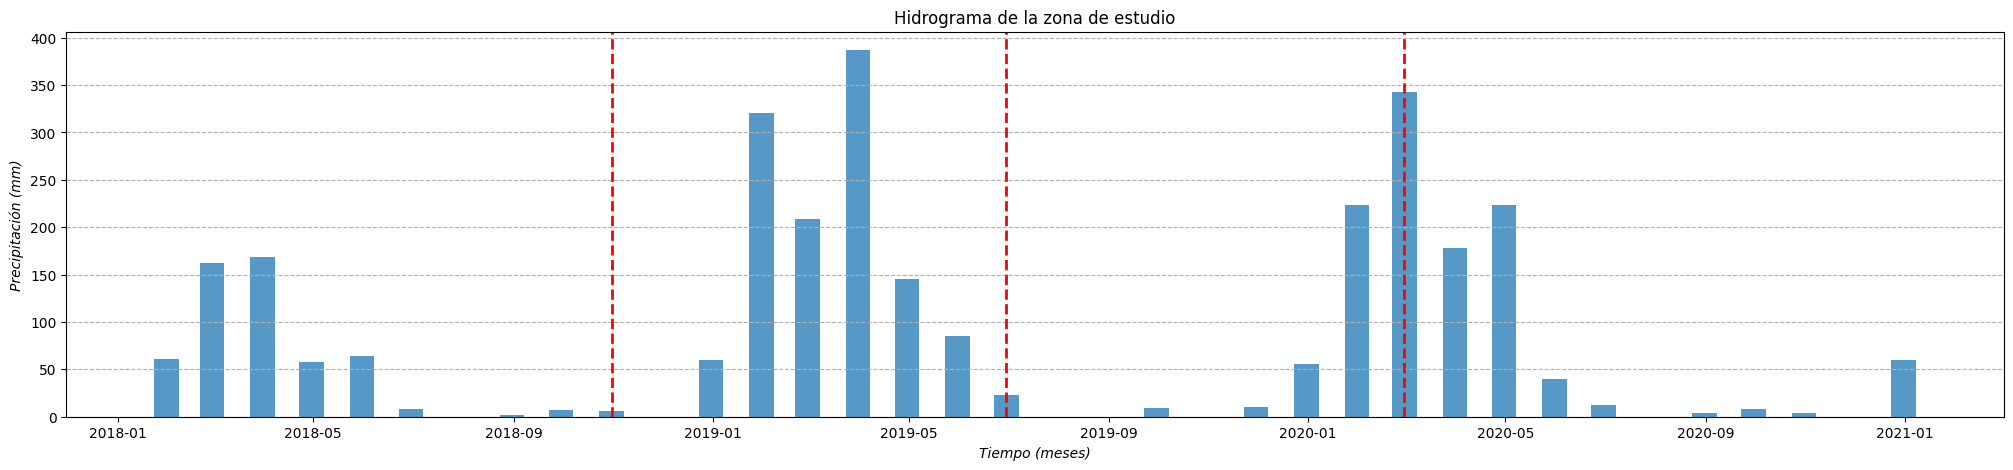

In [8]:
plt.figure(figsize = (25, 5))

plt.bar(puntos_chirps.index, puntos_chirps["precipitation"], width = 15, alpha = 0.75)

plt.axvline(x = pd.to_datetime("2018-10-31"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

plt.axvline(x = pd.to_datetime("2019-06-30"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

plt.axvline(x = pd.to_datetime("2020-02-29"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

plt.title("Hidrograma de la zona de estudio")

plt.xlabel("Tiempo (meses)", style = "italic")

plt.ylabel("Precipitación (mm)", style = "italic")

plt.grid(True, axis = "y", ls = "--")

plt.show()

In [9]:
fecha_inicial = '2018-01-01'; fecha_final = '2020-12-31'

temperatura =  ee.ImageCollection(ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")\
                             .select(['Tair_f_inst'])\
                             .filterDate(fecha_inicial, fecha_final))

puntos_red = create_reduce_region_function(geometry = centroide_ee, 
                                           reducer = ee.Reducer.first(), scale = 5000, crs = 'EPSG:4326')

temp_red = (ee.FeatureCollection(temperatura.map(puntos_red)).filter(ee.Filter.notNull(temperatura.first().bandNames())))

puntos_temp = fc_to_dict(temp_red).getInfo()

puntos_temp = pd.DataFrame(puntos_temp)

puntos_temp['Fecha'] = pd.to_datetime(puntos_temp["system:index"].str[1:], format='%Y%m%d_%H%M')

puntos_temp.set_index('Fecha', inplace=True)
    
puntos_temp = puntos_temp.drop(columns = ["millis", "system:index"])

puntos_temp = puntos_temp.copy() - 273

puntos_temp.T

Fecha,2018-01-01 00:00:00,2018-01-01 03:00:00,2018-01-01 06:00:00,2018-01-01 09:00:00,2018-01-01 12:00:00,2018-01-01 15:00:00,2018-01-01 18:00:00,2018-01-01 21:00:00,2018-01-02 00:00:00,2018-01-02 03:00:00,...,2020-12-29 18:00:00,2020-12-29 21:00:00,2020-12-30 00:00:00,2020-12-30 03:00:00,2020-12-30 06:00:00,2020-12-30 09:00:00,2020-12-30 12:00:00,2020-12-30 15:00:00,2020-12-30 18:00:00,2020-12-30 21:00:00
Tair_f_inst,25.359406,24.909454,24.182037,23.255432,23.102051,26.009155,30.334717,29.10257,26.226685,25.063843,...,33.580902,31.952576,27.714386,25.975708,23.627747,23.004761,23.534546,29.754547,33.380676,30.362671


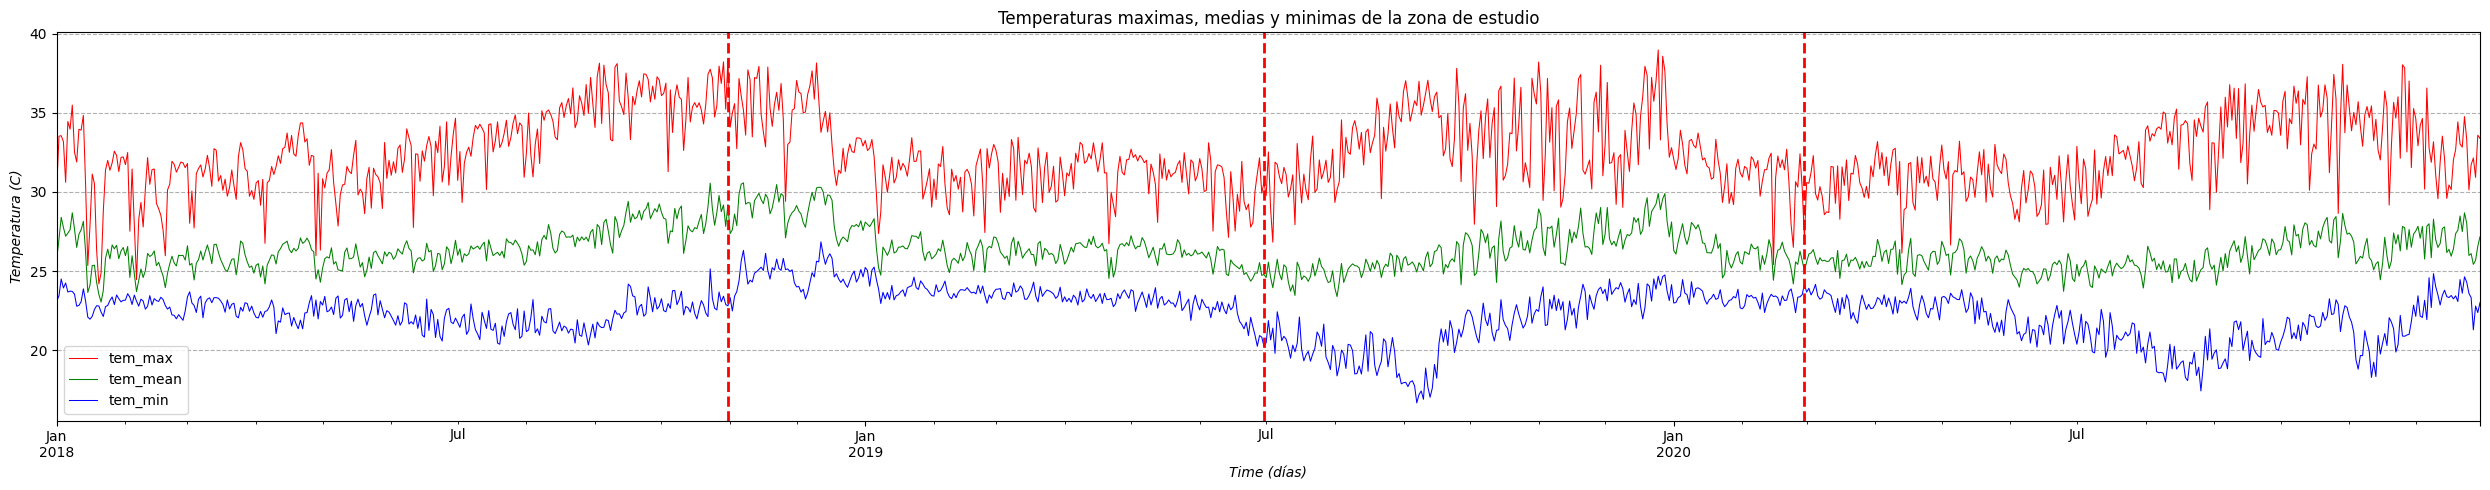

In [10]:
temp_df = pd.DataFrame({
    "tem_max": puntos_temp["Tair_f_inst"].resample('D').max(),
    "tem_mean": puntos_temp["Tair_f_inst"].resample('D').mean(),
    "tem_min": puntos_temp["Tair_f_inst"].resample('D').min(),
})

temp_df.plot(figsize = (25, 5), lw = 0.75, color = ["red", "green", "blue"])

plt.title("Temperaturas maximas, medias y minimas de la zona de estudio")

plt.axvline(x = pd.to_datetime("2018-10-31"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

plt.axvline(x = pd.to_datetime("2019-06-30"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

plt.axvline(x = pd.to_datetime("2020-02-29"), color = 'red', linestyle='--', linewidth = 2, label = 'Línea vertical: ')

# plt.fill_betweenx(y = np.linspace(0, 50, num = 1095), x1 = pd.to_datetime("2019-06-30"), x2 = pd.to_datetime("2020-02-29"))

plt.xlabel("Time (días)", style = "italic")

plt.ylabel("Temperatura (C)", style = "italic")

plt.grid(True, axis = "y", ls = "--")

plt.tight_layout()

plt.show()

# _Procesamiento de datos_

In [11]:
info1 = pd.read_excel("/kaggle/input/info-article-microbiological/1-s2.0-S2352801X23001340-mmc1.xlsx", 
                      skiprows = 1, skipfooter = 3, index_col = 0)
info1.iloc[24, 1] = 79.969997
info1.head()

,Latitude S,Longitude W,Status \nC: closed O:Open,Usage Irrigation UI-Consumption UC,Depth (m),Number of families that use the well,Number of people who benefit from the well,Septic distance,Activities and characteristics around,"Google Earth 19/11/2022 C: houses, S: crops, T: sand street, A: Trees"
Well number,,,,,,,,,,
1,1.747728,79.96074,C,"UC, UI",36,1,4,18.0,"OR, OP, OC, OD, H","C, S, A"
2,1.747491,79.963667,C,"UC, UI",40,1,4,NaN,"OR, OT, H","C, S, A"
3,1.746718,79.967299,C,UC,50,3,11,22.0,"OR, OP, OC","S,isolated >75 m"
4,1.747904,79.969088,C,UI,33,2,5,NaN,OR,"S, isolated >100 m"
5,1.747962,79.966651,C,"UC, UI",35,4,15,NaN,"OR, OG, H",C


In [12]:
info2 = pd.read_excel("/kaggle/input/info-article-microbiological/1-s2.0-S2352801X23001340-mmc2.xlsx", 
                      index_col = "Year", skipfooter=33)
info2.dropna(axis = 0, inplace = True)

info2.index = info2.index.astype(int)

info2.rename(columns = {"TE ": "TE"}, inplace = True)

info2_2018 = info2.loc[2018].reset_index().set_index("Well number").drop(columns = ["Year"])\
                    .rename(columns = {"pH": "pH_2018", "TE": "TE_2018", "TU": "TU_2018", "SA": "SA_2018"})
info2_2019 = info2.loc[2019].reset_index().set_index("Well number").drop(columns = ["Year"])\
                    .rename(columns = {"pH": "pH_2019", "TE": "TE_2019", "TU": "TU_2019", "SA": "SA_2019"})
info2_2020 = info2.loc[2020].reset_index().set_index("Well number").drop(columns = ["Year"])\
                    .rename(columns = {"pH": "pH_2020", "TE": "TE_2020", "TU": "TU_2020", "SA": "SA_2020"})

info2_2018.index = info2_2018.index.astype(int)
info2_2019.index = info2_2019.index.astype(int)
info2_2020.index = info2_2020.index.astype(int)


info2.head()

,Well number,pH,TE,TU,SA
Year,,,,,
2018,1.0,7.37,27.780,1.46,0.83
2018,2.0,7.08,27.570,0.99,0.60
2018,3.0,7.13,28.056,0.96,0.71
2018,4.0,6.52,27.510,0.22,0.73
2018,5.0,7.15,27.910,2.54,1.12


In [13]:
data = pd.concat([info1, info2_2018, info2_2019, info2_2020], axis = 1)
data.iloc[24, 1] = 79.969997
data["Latitude S"] = -data["Latitude S"].astype(float)
data["Longitude W"] = -data["Longitude W"].astype(float)
data.head()

,Latitude S,Longitude W,Status \nC: closed O:Open,Usage Irrigation UI-Consumption UC,Depth (m),Number of families that use the well,Number of people who benefit from the well,Septic distance,Activities and characteristics around,"Google Earth 19/11/2022 C: houses, S: crops, T: sand street, A: Trees",...,TU_2018,SA_2018,pH_2019,TE_2019,TU_2019,SA_2019,pH_2020,TE_2020,TU_2020,SA_2020
Well number,,,,,,,,,,,,,,,,,,,,,
1,-1.747728,-79.960740,C,"UC, UI",36,1,4,18.0,"OR, OP, OC, OD, H","C, S, A",...,1.46,0.83,6.22,27.24,2.398,0.93,NaN,NaN,NaN,NaN
2,-1.747491,-79.963667,C,"UC, UI",40,1,4,NaN,"OR, OT, H","C, S, A",...,0.99,0.60,6.41,27.22,2.615,0.66,7.05,27.9,4.20,0.67
3,-1.746718,-79.967299,C,UC,50,3,11,22.0,"OR, OP, OC","S,isolated >75 m",...,0.96,0.71,6.62,27.30,3.078,0.68,NaN,NaN,NaN,NaN
4,-1.747904,-79.969088,C,UI,33,2,5,NaN,OR,"S, isolated >100 m",...,0.22,0.73,6.30,27.16,2.706,0.92,NaN,NaN,NaN,NaN
5,-1.747962,-79.966651,C,"UC, UI",35,4,15,NaN,"OR, OG, H",C,...,2.54,1.12,6.77,22.56,2.558,1.12,6.83,28.1,2.61,1.14


# _Graficos_

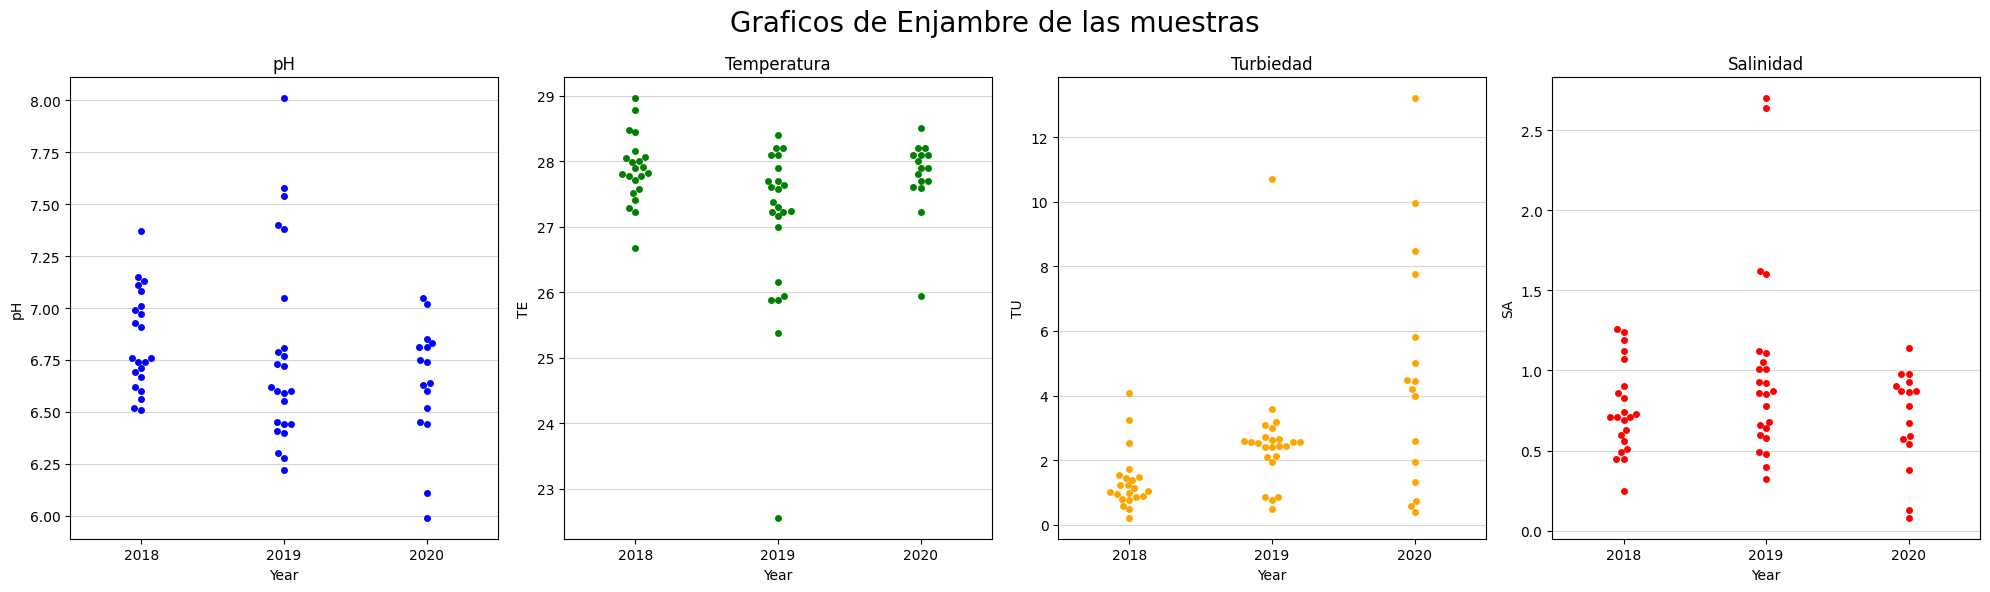

In [14]:
fig = plt.figure(figsize = (20, 6))

ax1, ax2, ax3, ax4 = fig.subplots(1, 4)

ax1.set_title("pH")
ax2.set_title("Temperatura")
ax3.set_title("Turbiedad")
ax4.set_title("Salinidad")

ax1.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax2.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax3.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax4.grid(axis = 'y', lw = 0.8, alpha = 0.5)

sns.swarmplot(data = info2, y = "pH", x = "Year", ax = ax1, color = "blue")
sns.swarmplot(data = info2, y = "TE", x = "Year", ax = ax2, color = "green")
sns.swarmplot(data = info2, y = "TU", x = "Year", ax = ax3, color = "orange")
sns.swarmplot(data = info2, y = "SA", x = "Year", ax = ax4, color = "red")

fig.suptitle('Graficos de Enjambre de las muestras', fontsize = 20, color = "black")

fig.tight_layout()

plt.show()

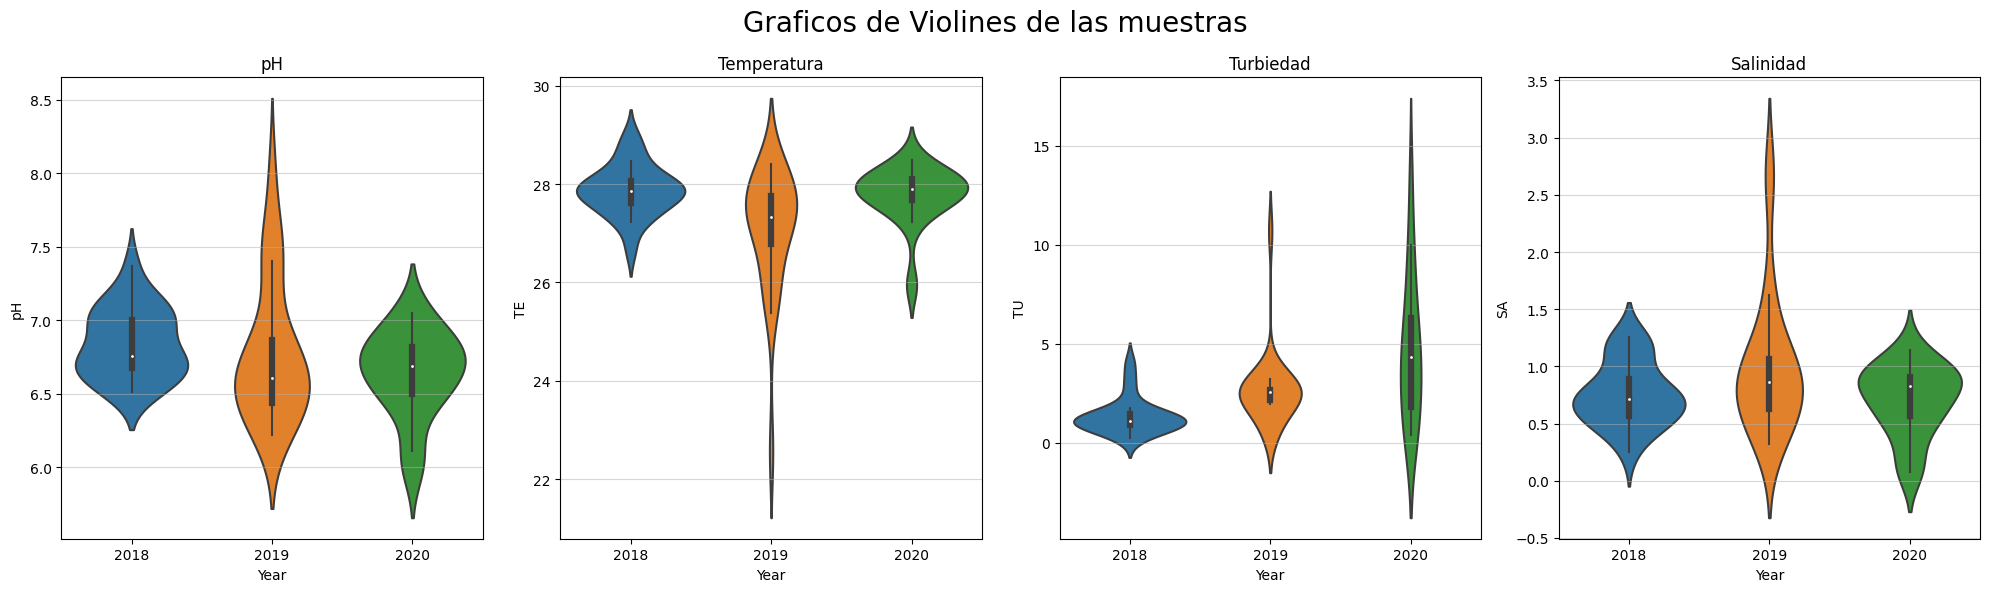

In [15]:
fig = plt.figure(figsize = (20, 6))

ax1, ax2, ax3, ax4 = fig.subplots(1, 4)

ax1.set_title("pH")
ax2.set_title("Temperatura")
ax3.set_title("Turbiedad")
ax4.set_title("Salinidad")

ax1.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax2.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax3.grid(axis = 'y', lw = 0.8, alpha = 0.5)
ax4.grid(axis = 'y', lw = 0.8, alpha = 0.5)


sns.violinplot(data=info2.reset_index(), x="Year", y="pH", ax = ax1)
sns.violinplot(data=info2.reset_index(), x="Year", y="TE", ax = ax2)
sns.violinplot(data=info2.reset_index(), x="Year", y="TU", ax = ax3)
sns.violinplot(data=info2.reset_index(), x="Year", y="SA", ax = ax4)

fig.suptitle('Graficos de Violines de las muestras', fontsize = 20, color = "black")

fig.tight_layout()

plt.show()

# Procesando los datos a información geospacial

In [16]:
vector = ee.FeatureCollection("FAO/GAUL/2015/level2")\
                    .filter(ee.Filter.eq("ADM2_NAME", "Santa Lucia"))\
                    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador"))

vector_gdf = geemap.ee_to_gdf(vector)

vector_gdf.crs = "EPSG:4326"

vector_gdf.to_crs(32717, inplace = True)

In [17]:
def df_to_gdfPoint(df):
    return shapely.geometry.Point(df['Longitude W'], df['Latitude S'])

data['geometry'] = data.apply(df_to_gdfPoint, axis=1)

data_gdf = gpd.GeoDataFrame(data, geometry='geometry', crs = "EPSG:4326")

data_gdf.to_crs(32717, inplace = True)

In [18]:
Map = leafmap.Map()

Map.add_basemap("HYBRID")

Map.add_gdf(area_gdf, style = {"color": "red", "fillOpacity": 0}, layer_name = "area de muestreo")

Map.add_heatmap(
    data_gdf,
    latitude = "Latitude S",
    longitude = "Longitude W",
    value = "Number of people who benefit from the well",
    name = "Heat map",
    radius = 38,
)

Map.add_points_from_xy(data = data_gdf[["Longitude W", "Latitude S", "Number of people who benefit from the well"]].reset_index(), 
                       x = "Longitude W", y="Latitude S", 
                       color_column = "Number of people who benefit from the well",
                       icon_names = ["users"]*13, layer_name = "test", spin=True,
                      add_legend = False, min_width = 10, marker_colors = ["blue"]*13)

Map

In [19]:
len(data_gdf[["Longitude W", "Latitude S", "Number of people who benefit from the well"]].reset_index())

26

In [20]:
Map = leafmap.Map()

Map.add_basemap("HYBRID")

Map.add_gdf(area_gdf, style = {"color": "red", "fillOpacity": 0}, layer_name = "area de muestreo")

septic_distance = data_gdf[["Longitude W", "Latitude S", "Septic distance"]]\
                        .dropna().reset_index().sort_values(by = "Septic distance")

septic_distance["Reverse septic distance"] = 40 - septic_distance["Septic distance"]

Map.add_heatmap(
    septic_distance,
    latitude = "Latitude S",
    longitude = "Longitude W",
    value = "Reverse septic distance",
    name = "Heat map",
    radius = 40,
)

Map.add_points_from_xy(data = septic_distance.drop("Reverse septic distance", axis = 1), 
                       x = "Longitude W", y="Latitude S", 
                       color_column = "Septic distance",
                       icon_names = ["trash"]*13, layer_name = "test", spin=True,
                      add_legend = False, min_width = 10, 
                       marker_colors = ["black"]*13)

Map

In [21]:
Map = leafmap.Map()

Map.add_basemap("HYBRID")

Map.add_gdf(area_gdf, style = {"color": "red", "fillOpacity": 0}, layer_name = "area de muestreo")

Map.add_points_from_xy(data = data_gdf, x = "Longitude W", y="Latitude S", 
                       color_column = "Usage Irrigation UI-Consumption UC",
                       icon_names = ["leaf", "male", "exchange"], layer_name = "test", spin = True,
                      add_legend = True, min_width = 10, marker_colors = ["green", "blue", "orange"])

Map

In [22]:
Map = leafmap.Map()


Map.add_basemap("HYBRID")

Map.add_gdf(area_gdf, style = {"color": "red", "fillOpacity": 0}, layer_name = "area de muestreo")

Map.add_points_from_xy(data = data_gdf, x = "Longitude W", y="Latitude S", 
                       color_column = "Status \nC: closed O:Open",
                       icon_names = ["dot-circle"]*2, layer_name = "test", spin=True,
                      add_legend = True, min_width = 10, icon_colors = ["white", "white"], marker_colors = ["red", "blue"])

Map

In [23]:
data_gdf['Depth (m)'] = data_gdf['Depth (m) '].replace('ND', np.nan)
data_gdf['Depth (m)'] = data_gdf['Depth (m)'].astype(float)

In [30]:
# parameters = info2[["pH", "TE", "TU", "SA"]]

# correlation_matrix = parameters.corr()

# plt.figure(figsize=(10, 8))

# sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', linewidths=0.5, fmt='.2f')

# plt.title('Heatmap de la Matriz de Correlación')

# plt.show()

In [25]:
# test[n].hist();

In [26]:
# n = "TU_2018"; shape = "spherical"
# n = "TU_2019"; shape = "exponential"

# n = "SA_2018"; shape = "exponential"
# n = "SA_2019"; shape = "exponential"
# n = "SA_2020"; shape = "exponential"

# n = "TE_2018"; shape = "exponential"
# n = "TE_2019"; shape = "exponential"
# n = "TE_2020"; shape = "exponential"
n = "Depth (m)"; shape = "gaussian"


test = data_gdf.dropna(subset=[n])

test_ee = geemap.gdf_to_ee(test)

sill = np.var(test[n])

nugget = sill * 0.1

Map = geemap.Map()

Map.add_basemap("HYBRID")

pp_img = test_ee.kriging(
    propertyName = n,
    shape = shape,
    range = 2250/4,
    sill = sill,
    nugget = nugget,
    maxDistance = 2250,
    reducer = ee.Reducer.mean(),
)

pp_img_result = pp_img.clip(area_ee)

min1_ = pp_img_result.reduceRegion(ee.Reducer.min(), geometry = area_ee, scale = 90).getInfo()[n]

max1_ = pp_img_result.reduceRegion(ee.Reducer.max(), geometry = area_ee, scale = 90).getInfo()[n]

contours_lines = geemap.create_contours(pp_img_result, min1_, max1_, (max1_ - min1_)/20, region = area_ee)

Map.centerObject(area_ee)

Map.addLayer(pp_img_result, {"palette": cmap.palettes.viridis, "min": min1_, "max": max1_}, "capa interpolada", opacity = 0.75)

Map.add_colorbar({"min": min1_, "max": max1_, "palette": cmap.palettes.viridis}, label = n, background_color = "white")

Map.addLayer(contours_lines, {"palette": "white"}, "lineas de contorno", opacity = 0.35)

Map.addLayer(test_ee, {"color": "orange"}, "puntos", shown = True)

Map.addLayer(ee.Image().paint(area_ee, 0, 3.5), {"palette": "red"}, "area de estudio")

Map.add_gdf(data_gdf[["geometry", n]], style = {"icon_color": "red"}, layer_name = "puntos 2")

Map.add_text(f"Param {n}", background = True, 
             bg_color = "black", fontcolor = "white", bold = True, position = "bottomright")

Map

In [27]:
def krigin_transform(data_gdf, area_ee, n, shape):
    test1 = data_gdf.dropna(subset=[n])
    test2 = geemap.gdf_to_ee(test1)
    
    sill = np.var(data_gdf[n])
    
    nugget = sill * 0.1
    
    test3 = test2.kriging(
        propertyName = n,
        shape = shape,
        range = 2250/2,
        sill = sill,
        nugget = nugget,
        maxDistance = 2250,
        reducer = ee.Reducer.mean(),
    )
    
    test4 = test3.clip(area_ee)

    return test4

In [28]:
pH_2018 = krigin_transform(data_gdf, area_ee, "pH_2018", "gaussian")
pH_2019 = krigin_transform(data_gdf, area_ee, "pH_2019", "gaussian")
pH_2020 = krigin_transform(data_gdf, area_ee, "pH_2020", "gaussian")

TE_2018 = krigin_transform(data_gdf, area_ee, "TE_2018", "gaussian")
TE_2019 = krigin_transform(data_gdf, area_ee, "TE_2019", "gaussian")
TE_2020 = krigin_transform(data_gdf, area_ee, "TE_2020", "gaussian")

TU_2018 = krigin_transform(data_gdf, area_ee, "TU_2018", "exponential")
TU_2019 = krigin_transform(data_gdf, area_ee, "TU_2019", "gaussian")
TU_2020 = krigin_transform(data_gdf, area_ee, "TU_2020", "gaussian")

SA_2018 = krigin_transform(data_gdf, area_ee, "SA_2018", "gaussian")
SA_2019 = krigin_transform(data_gdf, area_ee, "SA_2019", "gaussian")
SA_2020 = krigin_transform(data_gdf, area_ee, "SA_2020", "gaussian")


geemap.download_ee_image(pH_2018, "pH_2018.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(pH_2019, "pH_2019.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(pH_2020, "pH_2020.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TE_2018, "TE_2018.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TE_2019, "TE_2019.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TE_2020, "TE_2020.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TU_2018, "TU_2018.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TU_2019, "TU_2019.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(TU_2020, "TU_2020.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(SA_2018, "SA_2018.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(SA_2019, "SA_2019.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")
geemap.download_ee_image(SA_2020, "SA_2020.tif", scale = 10, region = area_ee.geometry(), crs = "EPSG:32717")

Image_pH_2018 = rasterio.open("pH_2018.tif")
Image_pH_2019 = rasterio.open("pH_2019.tif")
Image_pH_2020 = rasterio.open("pH_2020.tif")
Image_TE_2018 = rasterio.open("TE_2018.tif")
Image_TE_2019 = rasterio.open("TE_2019.tif")
Image_TE_2020 = rasterio.open("TE_2020.tif")
Image_TU_2018 = rasterio.open("TU_2018.tif")
Image_TU_2019 = rasterio.open("TU_2019.tif")
Image_TU_2020 = rasterio.open("TU_2020.tif")
Image_SA_2018 = rasterio.open("SA_2018.tif")
Image_SA_2019 = rasterio.open("SA_2019.tif")
Image_SA_2020 = rasterio.open("SA_2020.tif")

pH_2018.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


pH_2019.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

pH_2020.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TE_2018.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TE_2019.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TE_2020.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TU_2018.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TU_2019.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

TU_2020.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

SA_2018.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

SA_2019.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

SA_2020.tif: |          | 0.00/391k (raw) [  0.0%] in 00:00 (eta:     ?)

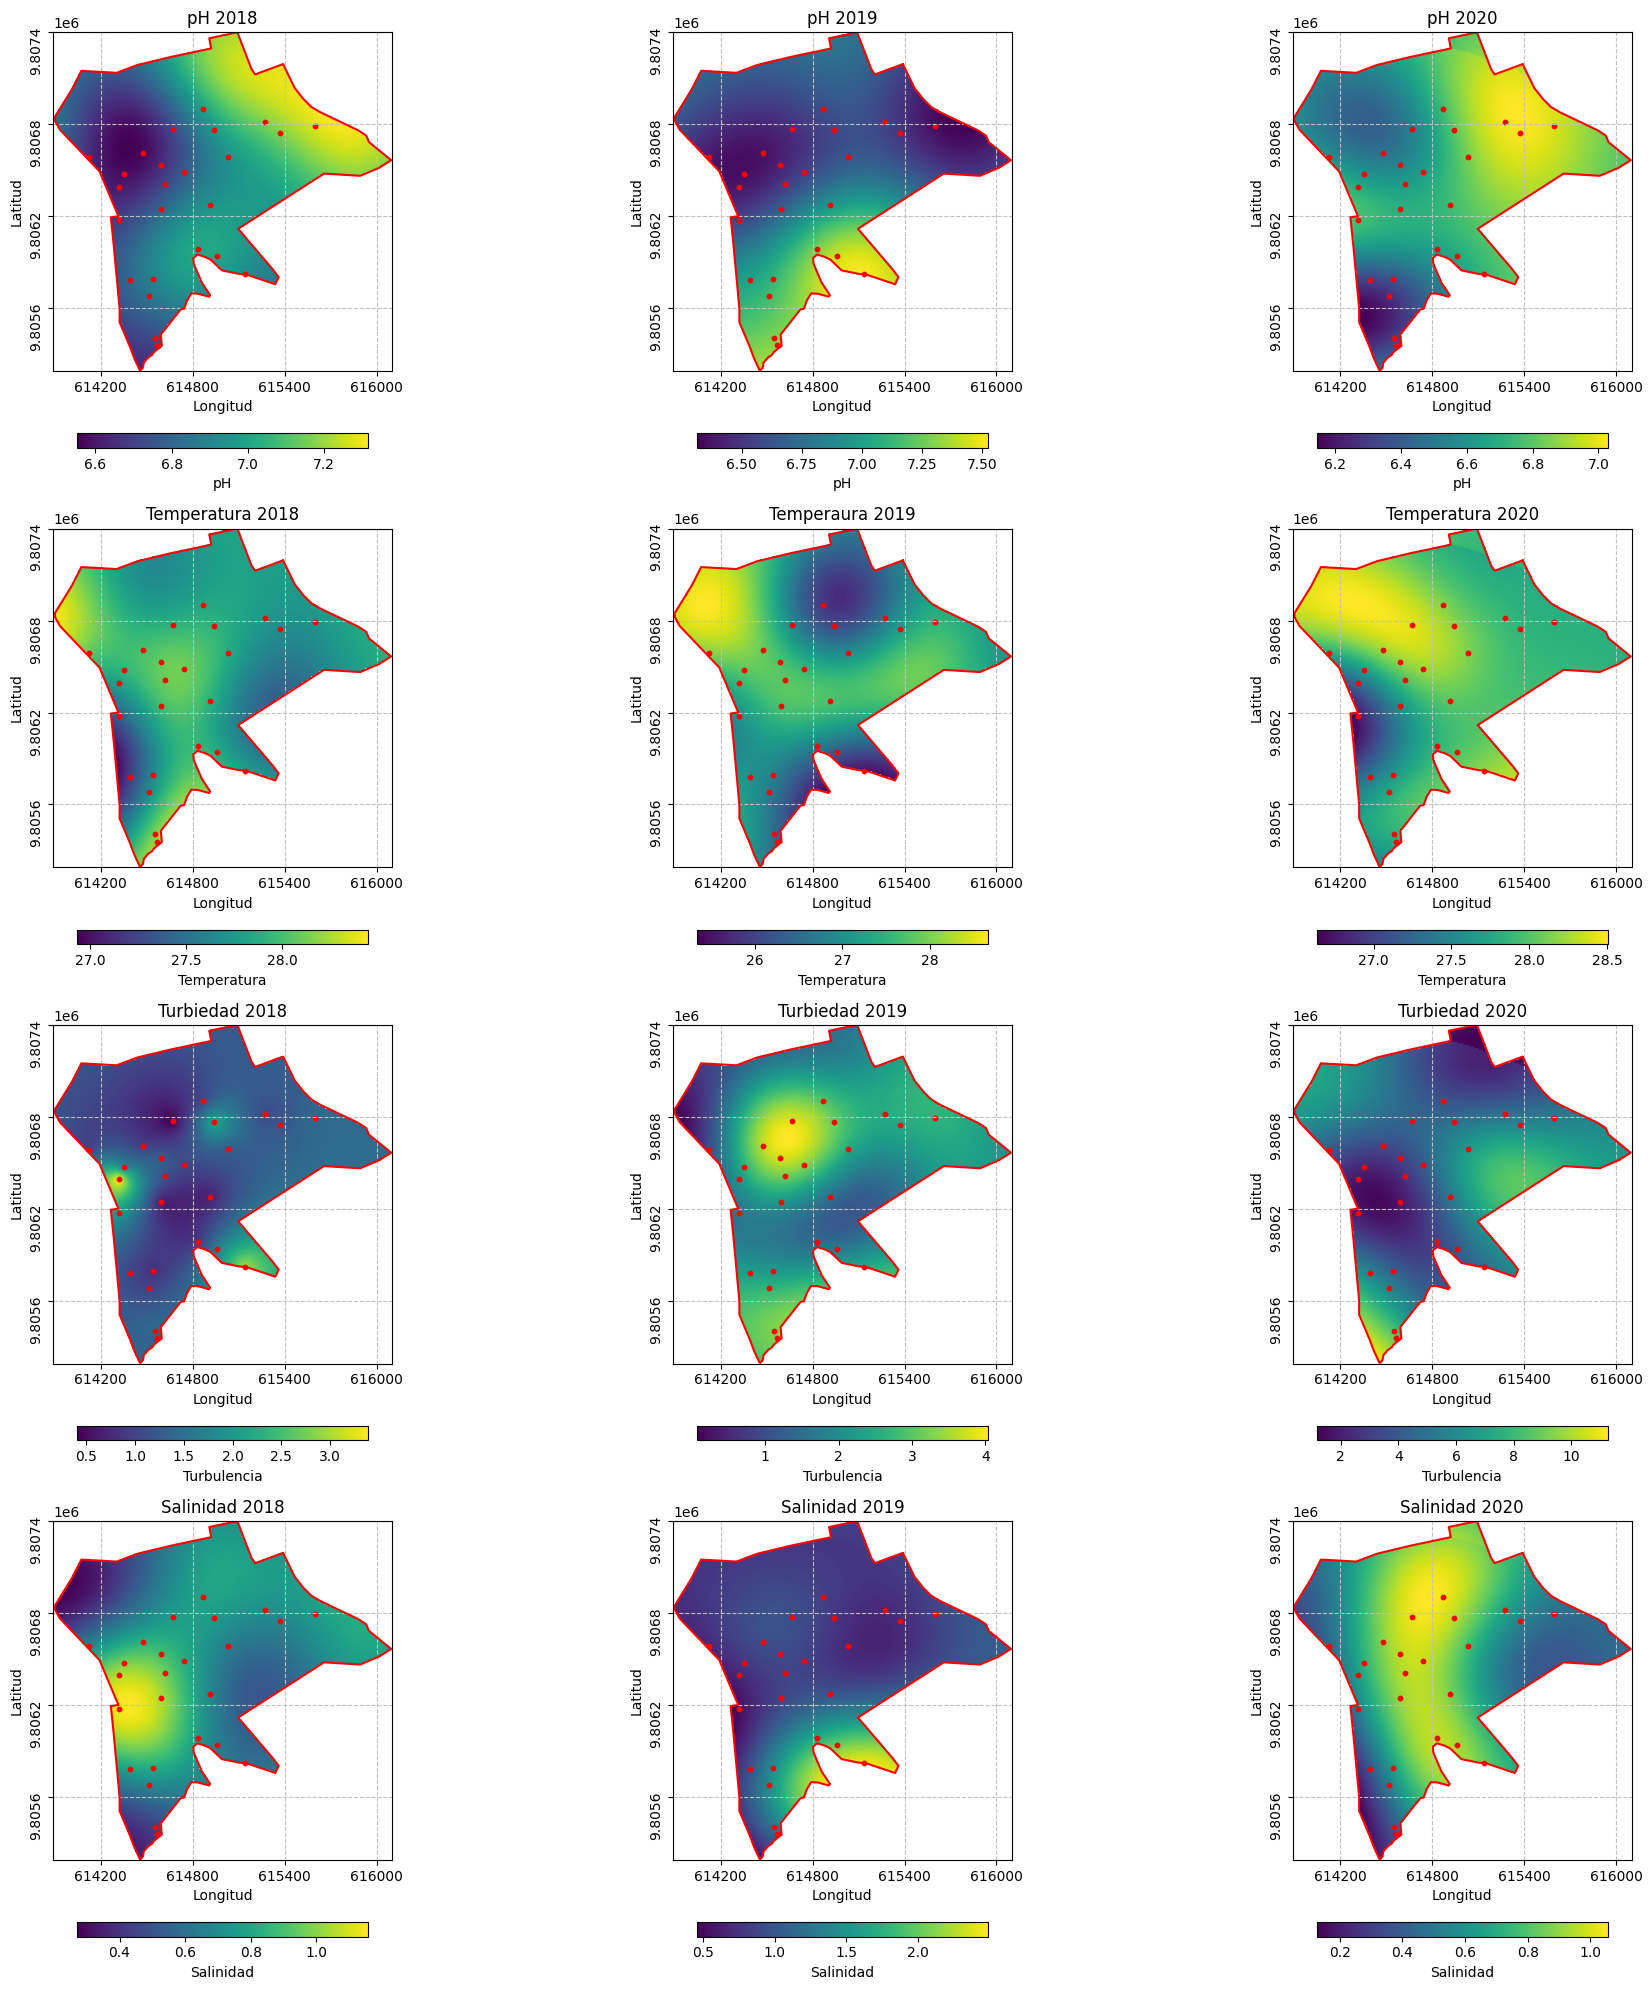

In [29]:
fig = plt.figure(figsize = (20, 20))

(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12) = fig.subplots(4, 3)

color_map = "viridis"

########################################################## parametro de pH #########################################################

im1 = rasterio.plot.show(Image_pH_2018, ax=ax1, cmap=color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax1, markersize = 10, marker='o')
area_gdf.boundary.plot(ax = ax1, color = "red")
ax1.set_title("pH 2018")
ax1.set_xlabel("Longitud")
ax1.set_ylabel("Latitud")
ax1.grid(True, c = "silver", linestyle = "--")
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_tick_params(rotation=90)
ax1.set_aspect('equal')

cbar1 = fig.colorbar(im1.get_images()[0], ax=ax1, orientation='horizontal', fraction = 0.035)
cbar1.set_label('pH')


im2 = rasterio.plot.show(Image_pH_2019, ax = ax2, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax2, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax2, color = "red")
ax2.set_title("pH 2019")
ax2.set_xlabel("Longitud")
ax2.set_ylabel("Latitud")
ax2.grid(True, c = "silver", linestyle = "--")
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_tick_params(rotation=90)
ax2.set_aspect('equal')

cbar2 = fig.colorbar(im2.get_images()[0], ax=ax2, orientation='horizontal', fraction = 0.035)
cbar2.set_label('pH')


im3 = rasterio.plot.show(Image_pH_2020, ax = ax3, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax3, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax3, color = "red")
ax3.set_title("pH 2020")
ax3.set_xlabel("Longitud")
ax3.set_ylabel("Latitud")
ax3.grid(True, c = "silver", linestyle = "--")
ax3.yaxis.set_major_locator(plt.MaxNLocator(4))
ax3.xaxis.set_major_locator(plt.MaxNLocator(4))
ax3.yaxis.set_tick_params(rotation=90)
ax3.set_aspect('equal')

cbar3 = fig.colorbar(im3.get_images()[0], ax=ax3, orientation='horizontal', fraction = 0.035)
cbar3.set_label('pH')


##################################################### parametro de temperatura #####################################################

im4 = rasterio.plot.show(Image_TE_2018, ax = ax4, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax4, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax4, color = "red")
ax4.set_title("Temperatura 2018")
ax4.set_xlabel("Longitud")
ax4.set_ylabel("Latitud")
ax4.grid(True, c = "silver", linestyle = "--")
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
ax4.xaxis.set_major_locator(plt.MaxNLocator(4))
ax4.yaxis.set_tick_params(rotation=90)
ax4.set_aspect('equal')

cbar4 = fig.colorbar(im4.get_images()[0], ax=ax4, orientation='horizontal', fraction = 0.035)
cbar4.set_label('Temperatura')


im5 = rasterio.plot.show(Image_TE_2019, ax = ax5, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax5, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax5, color = "red")
ax5.set_title("Temperaura 2019")
ax5.set_xlabel("Longitud")
ax5.set_ylabel("Latitud")
ax5.grid(True, c = "silver", linestyle = "--")
ax5.yaxis.set_major_locator(plt.MaxNLocator(4))
ax5.xaxis.set_major_locator(plt.MaxNLocator(4))
ax5.yaxis.set_tick_params(rotation=90)
ax5.set_aspect('equal')

cbar5 = fig.colorbar(im5.get_images()[0], ax=ax5, orientation='horizontal', fraction = 0.035)
cbar5.set_label('Temperatura')


im6 = rasterio.plot.show(Image_TE_2020, ax = ax6, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax6, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax6, color = "red")
ax6.set_title("Temperatura 2020")
ax6.set_xlabel("Longitud")
ax6.set_ylabel("Latitud")
ax6.grid(True, c = "silver", linestyle = "--")
ax6.yaxis.set_major_locator(plt.MaxNLocator(4))
ax6.xaxis.set_major_locator(plt.MaxNLocator(4))
ax6.yaxis.set_tick_params(rotation=90)
ax6.set_aspect('equal')

cbar6 = fig.colorbar(im6.get_images()[0], ax=ax6, orientation='horizontal', fraction = 0.035)
cbar6.set_label('Temperatura')



################################################## parametro de turbulencia ##############################################

im7 = rasterio.plot.show(Image_TU_2018, ax = ax7, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax7, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax7, color = "red")
ax7.set_title("Turbiedad 2018")
ax7.set_xlabel("Longitud")
ax7.set_ylabel("Latitud")
ax7.grid(True, c = "silver", linestyle = "--")
ax7.yaxis.set_major_locator(plt.MaxNLocator(4))
ax7.xaxis.set_major_locator(plt.MaxNLocator(4))
ax7.yaxis.set_tick_params(rotation=90)
ax7.set_aspect('equal')

cbar7 = fig.colorbar(im7.get_images()[0], ax=ax7, orientation='horizontal', fraction = 0.035)
cbar7.set_label('Turbulencia')


im8 = rasterio.plot.show(Image_TU_2019, ax = ax8, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax8, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax8, color = "red")
ax8.set_title("Turbiedad 2019")
ax8.set_xlabel("Longitud")
ax8.set_ylabel("Latitud")
ax8.grid(True, c = "silver", linestyle = "--")
ax8.yaxis.set_major_locator(plt.MaxNLocator(4))
ax8.xaxis.set_major_locator(plt.MaxNLocator(4))
ax8.yaxis.set_tick_params(rotation=90)
ax8.set_aspect('equal')

cbar8 = fig.colorbar(im8.get_images()[0], ax=ax8, orientation='horizontal', fraction = 0.035)
cbar8.set_label('Turbulencia')


im9 = rasterio.plot.show(Image_TU_2020, ax = ax9, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax9, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax9, color = "red")
ax9.set_title("Turbiedad 2020")
ax9.set_xlabel("Longitud")
ax9.set_ylabel("Latitud")
ax9.grid(True, c = "silver", linestyle = "--")
ax9.yaxis.set_major_locator(plt.MaxNLocator(4))
ax9.xaxis.set_major_locator(plt.MaxNLocator(4))
ax9.yaxis.set_tick_params(rotation=90)
ax9.set_aspect('equal')

cbar9 = fig.colorbar(im9.get_images()[0], ax=ax9, orientation='horizontal', fraction = 0.035)
cbar9.set_label('Turbulencia')


############################################## parametro de salinidad ####################################################

im10 = rasterio.plot.show(Image_SA_2018, ax = ax10, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax10, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax10, color = "red")
ax10.set_title("Salinidad 2018")
ax10.set_xlabel("Longitud")
ax10.set_ylabel("Latitud")
ax10.grid(True, c = "silver", linestyle = "--")
ax10.yaxis.set_major_locator(plt.MaxNLocator(4))
ax10.xaxis.set_major_locator(plt.MaxNLocator(4))
ax10.yaxis.set_tick_params(rotation = 90)
ax10.set_aspect('equal')

cbar10 = fig.colorbar(im10.get_images()[0], ax=ax10, orientation='horizontal', fraction = 0.035)
cbar10.set_label('Salinidad')


im11 = rasterio.plot.show(Image_SA_2019, ax = ax11, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax11, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax11, color = "red")
ax11.set_title("Salinidad 2019")
ax11.set_xlabel("Longitud")
ax11.set_ylabel("Latitud")
ax11.grid(True, c = "silver", linestyle = "--")
ax11.yaxis.set_major_locator(plt.MaxNLocator(4))
ax11.xaxis.set_major_locator(plt.MaxNLocator(4))
ax11.yaxis.set_tick_params(rotation = 90)
ax11.set_aspect('equal')

cbar11 = fig.colorbar(im11.get_images()[0], ax=ax11, orientation='horizontal', fraction = 0.035)
cbar11.set_label('Salinidad')


im12 = rasterio.plot.show(Image_SA_2020, ax = ax12, cmap = color_map)
data_gdf.plot(color = "red", figsize = (15, 15), ax = ax12, markersize = 10, marker='o')
area_gdf.boundary.plot(ax=ax12, color = "red")
ax12.set_title("Salinidad 2020")
ax12.set_xlabel("Longitud")
ax12.set_ylabel("Latitud")
ax12.grid(True, c = "silver", linestyle = "--")
ax12.yaxis.set_major_locator(plt.MaxNLocator(4))
ax12.xaxis.set_major_locator(plt.MaxNLocator(4))
ax12.yaxis.set_tick_params(rotation = 90)
ax12.set_aspect('equal')

cbar12 = fig.colorbar(im12.get_images()[0], ax=ax12, orientation='horizontal', fraction = 0.035)
cbar12.set_label('Salinidad')


################################################ configuracion standart ####################################################

fig.tight_layout();

<img src = "https://ars.els-cdn.com/content/image/1-s2.0-S2352801X23001340-gr3_lrg.jpg" width="1500">

Despues continuo y arreglo detalles...